# Predict Complaint Types

The goal of this exercise is to do Model Development and Validation to find the answer to the Question 4 of the problem statement:

### Can a predictive model be built for future prediction of the possibility of complaints of the specific type that you identified in response to Question 1?

In this exercise, you will use a feature-engineered dataset to determine whether a predictive model can be built to predict the complaint (of the Complaint Type that you decided to focus on in Week 2) by using past data.

Using the best model, you need to predict the number of future complaints (of the Complaint Type that you decided to focus on in Question 1).

Add your answer to this question along with code and comments in a separate notebook. Upload the notebook in the subsection called "Question 4 - Can a predictive model be built for future prediction of the possibility of Complaints of the specific type that you identified in response to Question 1?" in the section "Submit your work and Review your Peer's work" in the module "Submit Your Work and Grade Your Peers".

In [1]:
%%capture 
!pip install pandas
!pip install sklearn
!pip install folium
!pip install pandas-profiling
!pip install xgboost

In [2]:
import pandas as pd
import numpy as np

In [3]:
NY_311 = pd.read_csv("fhrw-4uyv.csv", parse_dates=['created_date', "closed_date"], infer_datetime_format=True)

In [4]:
NY_311_BX = NY_311[NY_311.borough == "BRONX"].dropna()

In [5]:
NY_311_BX = NY_311_BX.assign(day=NY_311_BX.created_date.dt.date)

In [6]:
def encode_heat_related( cat ):
    if cat in ['HEAT/HOT WATER', 'HEATING']:
        return "HEAT"
    else:
        return "NONE HEAT"

In [7]:
def label_encode_heat_related( cat ):
    if cat in ['HEAT/HOT WATER', 'HEATING']:
        return 1
    else:
        return 0

In [8]:
NY_311_BX = NY_311_BX.assign(heat_problems=NY_311_BX.complaint_type.apply(label_encode_heat_related))
NY_311_BX.head()


created_date  unique_key  complaint_type  incident_zip  \
539 2019-10-22 01:36:17    44124662  HEAT/HOT WATER       10452.0   
686 2019-10-26 11:12:05    44156604      WATER LEAK       10468.0   
761 2019-10-25 14:33:24    44150040  HEAT/HOT WATER       10463.0   
775 2019-10-25 12:49:34    44149279  HEAT/HOT WATER       10458.0   
796 2019-10-25 15:13:16    44148429  HEAT/HOT WATER       10463.0   

          incident_address        street_name address_type   city  \
539  957 WOODYCREST AVENUE  WOODYCREST AVENUE      ADDRESS  BRONX   
686       2710 WEBB AVENUE        WEBB AVENUE      ADDRESS  BRONX   
761   163 WEST  231 STREET   WEST  231 STREET      ADDRESS  BRONX   
775     2503 HUGHES AVENUE      HUGHES AVENUE      ADDRESS  BRONX   
796   163 WEST  231 STREET   WEST  231 STREET      ADDRESS  BRONX   

                                resolution_description borough   latitude  \
539  The Department of Housing Preservation and Dev...   BRONX  40.831527   
686  The Department of Housing Preservation and Dev...   BRONX  40.869486   
761  The Department of Housing Preservation and Dev...   BRONX  40.878328   
775  The Department of Housing Preservation and Dev...   BRONX  40.857772   
796  The Department of Housing Preservation and Dev...   BRONX  40.878328   

     longitude         closed_date         location_type  status         day  \
539 -73.928863 2019-10-22 22:02:58  RESIDENTIAL BUILDING  Closed  2019-10-22   
686 -73.902092 2019-10-26 17:59:57  RESIDENTIAL BUILDING  Closed  2019-10-26   
761 -73.903207 2019-10-25 16:41:06  RESIDENTIAL BUILDING  Closed  2019-10-25   
775 -73.884714 2019-10-27 02:05:02  RESIDENTIAL BUILDING  Closed  2019-10-25   
796 -73.903207 2019-10-25 16:41:06  RESIDENTIAL BUILDING  Closed  2019-10-25   

     heat_problems  
539              1  
686              0  
761              1  
775              1  
796              1

In [9]:
per_zip_per_week = NY_311_BX.groupby('incident_zip').resample('1W',on="created_date").sum()
per_zip_per_week = per_zip_per_week.drop(columns=['incident_zip',"unique_key","latitude","longitude"])

In [10]:
per_zip_per_week = per_zip_per_week.assign(start_of_week=per_zip_per_week.index.get_level_values("created_date"))
per_zip_per_week.head()


heat_problems start_of_week
incident_zip created_date                             
10451.0      2011-03-13               51    2011-03-13
             2011-03-20               41    2011-03-20
             2011-03-27               55    2011-03-27
             2011-04-03               68    2011-04-03
             2011-04-10               43    2011-04-10

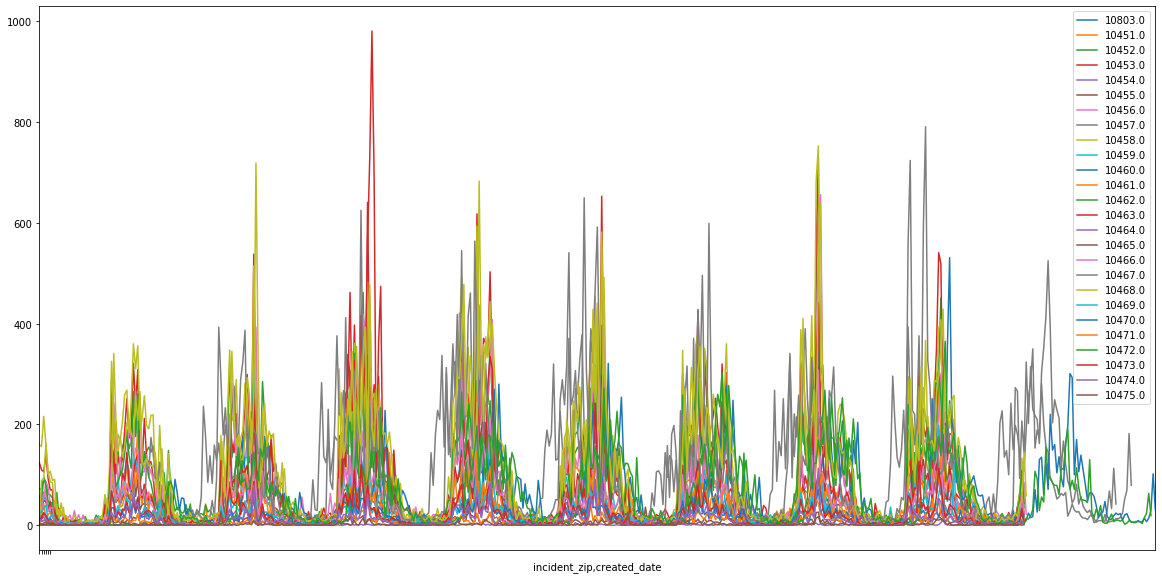

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(20, 10))

zipcodes_list = []
for zipcode in set(per_zip_per_week.index.get_level_values("incident_zip")):
    per_zip_per_week[per_zip_per_week.index.get_level_values("incident_zip")==zipcode].heat_problems.plot(ax=ax)
    zipcodes_list.append(zipcode)
    
ax.set_xticklabels([])
ax.legend(zipcodes_list)

## COMMENTS

- There is clearly a seasonal trend in heat related problems (colder months more problems)
- Data is not clean/complete, latter weeks shows lack of data of certain postal codes
- Due to missing data, we will focus on data up to and including 2018

In [12]:
#
# It is possible to add lagging feature within groups, but this is complicated and not needed
#
#
"""
incidents_1_week_lag = per_zip_per_week.groupby(["incident_zip"], as_index=False).shift(1)
incidents_1_week_lag = incidents_1_week_lag.rename(columns={"heat_problems": "lag_1_week"})
incidents_1_week_lag = incidents_1_week_lag.drop(columns=["start_of_week"])
incidents_1_week_lag.head()
"""

'\nincidents_1_week_lag = per_zip_per_week.groupby(["incident_zip"], as_index=False).shift(1)\nincidents_1_week_lag = incidents_1_week_lag.rename(columns={"heat_problems": "lag_1_week"})\nincidents_1_week_lag = incidents_1_week_lag.drop(columns=["start_of_week"])\nincidents_1_week_lag.head()\n'

In [13]:
NY_311_BX.index = NY_311_BX.created_date

## Exclude 2019 - As clearly the upper plot shows missing values for many zip codes

In [14]:
NY_311_BX = NY_311_BX[ NY_311_BX.index.year <= 2018 ]

## Plot Heat Problems for each week

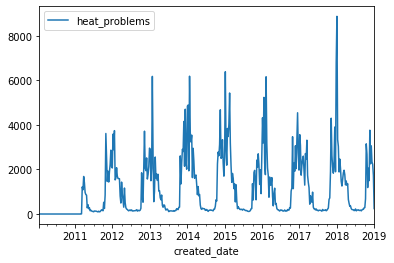

In [15]:
heat_problem_each_week = NY_311_BX.resample("1W").agg({'heat_problems':'sum'})

heat_problem_each_week.plot()

## COMMENTS

- Clearly, a seasonal trend
- Weird behaviour around 2018 - might be due to lag of problem processing, showing a sudden peak (financial crisis?)

## Plot average of problems in each week

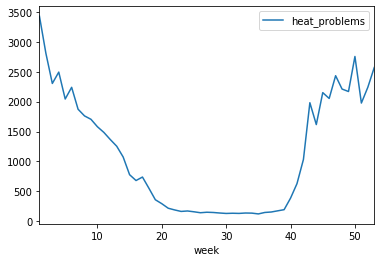

In [16]:
heat_problem_each_week = heat_problem_each_week.assign(week=heat_problem_each_week.index.week)
heat_problem_each_week.groupby('week').mean().plot()

## COMMENTS

- The above plot can already be used as a fairly effective model to predict the number of problems for each week.
- We are going to imporive the above model by making a XGBoost with lagging features

In [17]:
heat_problem_each_week.head()

heat_problems  week
created_date                     
2010-01-17                1     2
2010-01-24                0     3
2010-01-31                2     4
2010-02-07                0     5
2010-02-14                0     6

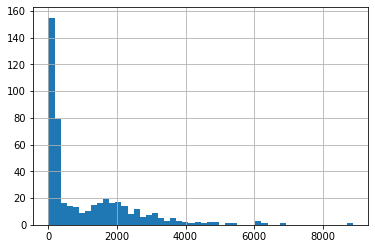

In [18]:
%matplotlib inline

_ = heat_problem_each_week.heat_problems.hist(bins=50,)

## Adding Laggin' Features

In [19]:
def add_prev_week(data, num_weeks, column="heat_problems"):
    data['prev_%d' % num_weeks] = data[column].shift(num_weeks)

def add_mean(data, num_weeks, column="heat_problems"):
    """
    Add the shift(1) to prevent data-leakage
    """
    data['mean_%d' % num_weeks] = data[column].rolling(window=num_weeks).mean().shift(1)

def add_std(data, num_weeks, column="heat_problems"):
    """
    Add the shift(1) to prevent data-leakage
    """
    data['std_%d' % num_weeks] = data[column].rolling(window=num_weeks).std().shift(1)

In [20]:
heat_problems_with_features = heat_problem_each_week.copy()

In [21]:
add_prev_week(heat_problems_with_features,1)
add_prev_week(heat_problems_with_features,2)

add_mean(heat_problems_with_features,3)
add_mean(heat_problems_with_features,4)

add_std(heat_problems_with_features,2)
add_std(heat_problems_with_features,3)

In [22]:
heat_problems_with_features.head(10)

heat_problems  week  prev_1  prev_2    mean_3  mean_4     std_2  \
created_date                                                                    
2010-01-17                1     2     NaN     NaN       NaN     NaN       NaN   
2010-01-24                0     3     1.0     NaN       NaN     NaN       NaN   
2010-01-31                2     4     0.0     1.0       NaN     NaN  0.707107   
2010-02-07                0     5     2.0     0.0  1.000000     NaN  1.414214   
2010-02-14                0     6     0.0     2.0  0.666667    0.75  1.414214   
2010-02-21                0     7     0.0     0.0  0.666667    0.50  0.000000   
2010-02-28                0     8     0.0     0.0  0.000000    0.50  0.000000   
2010-03-07                0     9     0.0     0.0  0.000000    0.00  0.000000   
2010-03-14                0    10     0.0     0.0  0.000000    0.00  0.000000   
2010-03-21                0    11     0.0     0.0  0.000000    0.00  0.000000   

                 std_3  
created_date            
2010-01-17         NaN  
2010-01-24         NaN  
2010-01-31         NaN  
2010-02-07    1.000000  
2010-02-14    1.154701  
2010-02-21    1.154701  
2010-02-28    0.000000  
2010-03-07    0.000000  
2010-03-14    0.000000  
2010-03-21    0.000000

## COMMENTS

- By adding laggin features, we can use XGBoost or similar models to predict the future

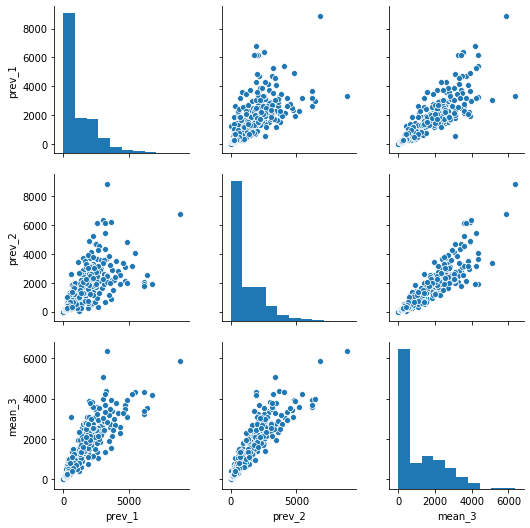

In [24]:
%matplotlib inline

import seaborn as sns

grid = sns.pairplot(heat_problems_with_features, x_vars=['prev_1', 'prev_2', 'mean_3'], y_vars=['prev_1', 'prev_2', 'mean_3'])
grid

## COMMENTS

- Graphs show hopeful relation between previous weeks and number of problems

In [25]:
from sklearn.model_selection import train_test_split, KFold

FEATURES = ['week', 'prev_1', 'prev_2', 'mean_3', 'mean_4',
       'std_2', 'std_3']
TARGET = 'heat_problems'

x_train, x_test, y_train, y_test = train_test_split(heat_problems_with_features[FEATURES], heat_problems_with_features[TARGET])

In [27]:
import xgboost as xgb

dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test)

params = {
    'objective' : 'reg:squarederror',
    'min_child_weight' : 35,
    'eta' : 0.05,
    'seed' : 0,
    'gamma': 0,
    'max_depth': 4,
}

hist = xgb.cv(params, dtrain, nfold=3, as_pandas=True, num_boost_round=250, verbose_eval=40, early_stopping_rounds=500, show_stdv=True, seed=0)

[0]	train-rmse:1646.57+65.3187	test-rmse:1645.33+125.227
[40]	train-rmse:743.29+51.8856	test-rmse:818.328+86.9418
[80]	train-rmse:677.568+51.7954	test-rmse:791.922+104.914
[120]	train-rmse:649.145+49.5826	test-rmse:796.827+106.74
[160]	train-rmse:631.082+47.8897	test-rmse:804.503+107.502
[200]	train-rmse:615.566+46.927	test-rmse:810.032+106.361
[240]	train-rmse:602.193+46.3717	test-rmse:814.74+103.541
[249]	train-rmse:599.279+46.549	test-rmse:815.819+104.106


## COMMENTS

- XGBoost is doing fairly well - and with use of min_child_weight we have reduces overfit problem
- To check, we are going to plan about 5 weeks ahead, by re-predicting on previous predictions

In [28]:
bst = xgb.train(params, dtrain, num_boost_round=250, verbose_eval=10)

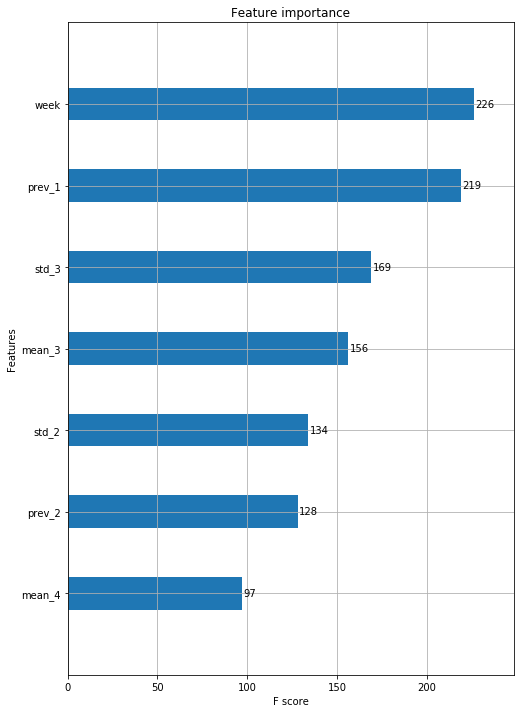

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8, 12))

xgb.plot_importance(bst, ax=ax, height=0.4)

## COMMENTS

- Current week is most important to predict number of heat problemns, which translates to time of the year.
- Previous week is 2nd most important


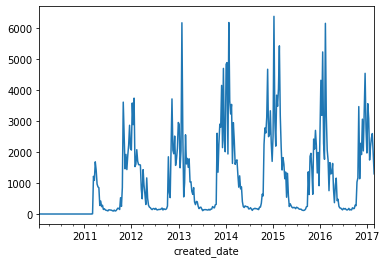

In [31]:
heat_problems_with_features[heat_problems_with_features.index <= '2017-3-01'].heat_problems.plot()

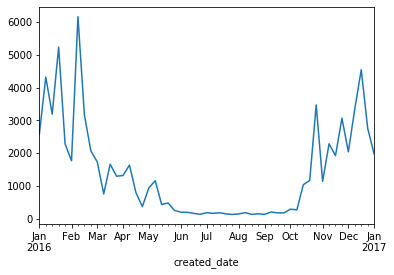

In [32]:
subset_to_predict = heat_problems_with_features.copy()
subset_to_predict = subset_to_predict[(subset_to_predict.index >= '2016-01-01') & (subset_to_predict.index <= '2017-01-01')]
subset_to_predict.heat_problems.plot()

In [33]:
def recalculate_laggin_features( df ):
    add_prev_week(df,1)
    add_prev_week(df,2)

    add_mean(df,3)
    add_mean(df,4)

    add_std(df,2)
    add_std(df,3)

In [34]:
subset_to_predict = subset_to_predict.assign( prediction=bst.predict( xgb.DMatrix( subset_to_predict[FEATURES]) ))
subset_to_predict = subset_to_predict.assign( actuals=subset_to_predict.heat_problems )

In [35]:
for week_ix in [7,6,5,4,3,2,1]:
    subset_to_predict.assign( prediction=bst.predict( xgb.DMatrix( subset_to_predict[FEATURES]) ))
    week_index = len(subset_to_predict) - week_ix
    #print(subset_to_predict.iloc[week_index,:])
    subset_to_predict.iloc[week_index,0] = subset_to_predict.iloc[week_index,8]
    recalculate_laggin_features(subset_to_predict)

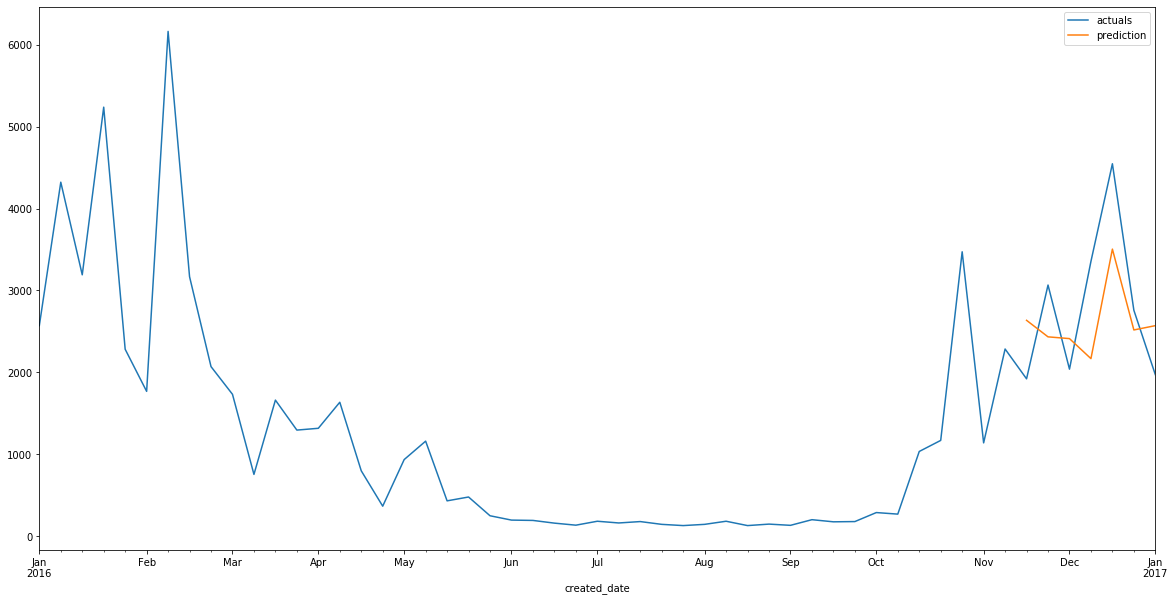

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(20, 10))

subset_to_predict.actuals.plot(legend=True, ax=ax)
subset_to_predict[subset_to_predict.index >= '2016-11-20'].prediction.plot(legend=True, ax=ax)

## COMMENTS

- A very simple and effective model to predict the number of problems in next week, is to take the histical week averages
- Model can be improved by creating an XGBoost, based on laggin features are previous week, and std of past X weeks.
- Above graph shows XGBoost predicting each week from '2016-11-20' to end of that year
- Note that - XGBoost is predicting not week-by-week, but the whole period based on data up-to '2016-11-20'
